# EDS 296 Homework 1

Author: Haylee Oyler

[Link to notebook on Github](https://github.com/haylee360/eds296-hw1/blob/main/eds296-hw1-hoyler.ipynb)

https://github.com/haylee360/eds296-hw1/blob/main/eds296-hw1-hoyler.ipynb

## Instructions

Locate monthly data for a historical simulation run with any two CMIP6 models of your
choice. 

You may choose any climate variable you like; however, note that three-dimensional data is
generally larger and can be slower to load, so I recommend either choosing a two-
dimensional data field or reading in only the surface level if you choose 3D information.
Some common choices of variables to analyze, and their CMIP names, include:

- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)

Download (or write Python code to access via the cloud) data from the historical simulation,
as well as corresponding future projection information for two different future emissions
scenarios, for each model. NOTE: particularly if you’re working with the ESGF, there are
many different scenarios listed - let’s stick to the main SSPs (they will be called ‘ssp126’,
‘ssp245’, ‘ssp370’, or ‘ssp585’

Choose a region that you’re interested in to analyze, anywhere in the world. The only
constraint is that your region needs to be large enough to include at least one model grid
point

a. Describe, in markdown text, the climate of that region in general terms. What is it like? Is
it a forest, a desert, polar, tropical, urban, etc? What types of climate change impacts might
you expect there?

b. Read in the surface air temperature datasets from 1 and 2, and create annually averaged,
area-weighted, regionally averaged time series for your region of interest. (Examples of how
to do this can be found in the various Time Series Plots tutorials we used in class.)

Since you’re working with two models and two scenarios, this should result in four time
series — however, if you used the same historical ensemble member for multiple scenarios,
they will end up lying on top of each other and that’s ok

Plot your regional time series, and fit a trend line for two different time periods:
- historical (1850-2015)
- historical plus future (1850-2100)
Over both of those time periods, is the temperature of your region changing, and is that
change statistically significant

Write 1-2 paragraphs in markdown text describing the results of your plot, and what you
think they might mean for humans or ecosystems located in your study region

In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import intake
import s3fs
import numpy as np 

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

My area of interest is the Congo Basin in West Africa. Through some basic googling, I've found two models that appear well suited to documenting climate changes in that region: GFDL-ESM4 and INM-CM5-0. These are the Institute for Numerical Mathematics (INM) climate model version 5 generation 0 and the Geophysical Fluid Dynamics Laboratory earth systems model 4.

### Catalog search

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
source_id = ['GFDL-ESM4' ,'INM-CM5-0']

# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r1i1p1f1'

# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon' 

# variable_id: I chose precipitation flux in kg m-2 s-1, it includes both liquid and solid phases.
variable_id = 'pr' 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, 
                     experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id,
                     member_id=member_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/CMIP/INM/INM-CM5-0/histor...,NaN,20190610
5,ScenarioMIP,INM,INM-CM5-0,ssp370,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190618
6,ScenarioMIP,INM,INM-CM5-0,ssp126,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
7,ScenarioMIP,INM,INM-CM5-0,ssp245,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
8,ScenarioMIP,INM,INM-CM5-0,ssp585,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190724
9,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,pr,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


### Model selection and cleaning

Let's separate our data by their respective model sources and selected the historical data and two future projections for each.

In [5]:
# Read in the historical data file for INM
hist_inm = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_inm = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Read in the SSP245 data file
ssp245_inm = xr.open_zarr(res.df['zstore'][7], storage_options={'anon': True})

In [6]:
# Read in the historical data file for GFDL
hist_gfdl = xr.open_zarr(res.df['zstore'][9], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_gfdl = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

# Read in the SSP245 data file
ssp245_gfdl = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

In [7]:
# Concatenate historical and future projection data for the 245 and 270 projections for both models
inm_245 = xr.concat([hist_inm, ssp245_inm], dim="time")

inm_370 = xr.concat([hist_inm, ssp370_inm], dim="time")

gfdl_245 = xr.concat([hist_gfdl, ssp245_gfdl], dim="time")

gfdl_370 = xr.concat([hist_gfdl, ssp370_gfdl], dim="time")


### Site Selection - The Congo Basin

My area of interest is going to be the Congo Basin in West Africa. The Congo Basin is home to one of the largest rainforests in the world and understanding how carbon storage and other biogeochemical fluxes will change under the influence of climate change is crucial. 


### Plotting for INM model

Let's start with the historical graph for the INM model. Since both projections (245 and 370) come from the same ensemble, it doesn't matter which dataset we use here when looking at the historical time period. We'll arbitrarily use the `inm_370` in this case.

In [28]:
# Select tas variable, store as xarray DataArray
pr_inm_370 = inm_370['pr']

# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 9.3, 13.4
lon_min, lon_max = 12, 34


#### Weighting by area

In [29]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

# Weight our INM precipitation data
pr_inm_370 = weights(pr_inm_370)

In [30]:
# Subsetting for INM model
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_inm_370 = (pr_inm_370.lat >= lat_min) & (pr_inm_370.lat <= lat_max)
congo_lon_inm_370 = (pr_inm_370.lon >= lon_min) & (pr_inm_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_inm_370 = pr_inm_370.where(congo_lat_inm_370 & congo_lon_inm_370, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_inm_370 = pr_congo_inm_370.mean(dim=["lat", "lon"])

We have two time periods of interest: 
- historical (1850-2015)
- historical plus future (1850-2100)

In [31]:
# Converts calendar to standard format to troublshoot slicing errors
pr_congo_inm_370 = pr_congo_inm_370.convert_calendar('standard', use_cftime=False)

# Select a time period of interest
pr_congo_inm_370 = pr_congo_inm_370.sel(time=slice('1850-01-01', '2015-12-31'))

In [32]:
# Calculate the annual mean precipitation
annual_mean_inm_370 = pr_congo_inm_370.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_inm_370 = np.polyfit(annual_mean_inm_370.year, annual_mean_inm_370, 1)

# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x_inm_370)  

### Model 1 Historical Plot

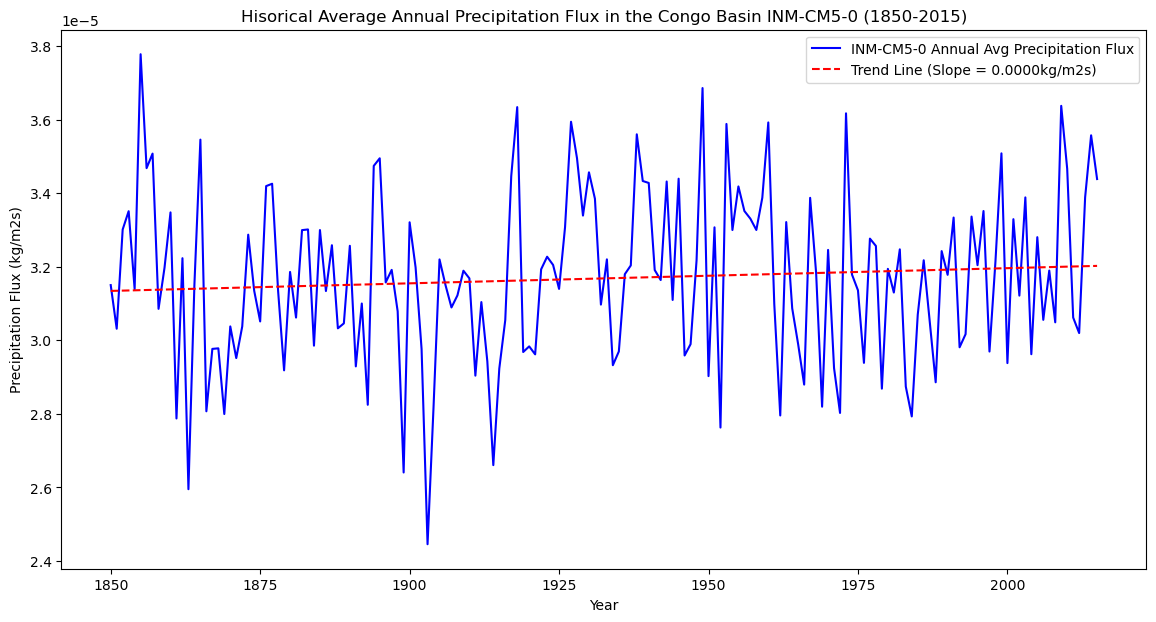

In [ ]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_inm_370.year, annual_mean_inm_370, label= 'INM-CM5-0 Annual Avg Precipitation Flux', color='blue')
ax.plot(annual_mean_inm_370.year, trend_line(annual_mean_inm_370.year), color='red', linestyle='--', label=f'Trend Line (Slope = {x_inm_370[0]:.4f}kg/m2s)')
ax.set_title('Hisorical Average Annual Precipitation Flux Weight by Area\nin the Congo Basin INM-CM5-0 (1850-2015)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()

Now, let's plot the historical data with the future projections for the 245 and 370 projections

In [34]:
# Select tas variable, store as xarray DataArray
pr_inm_245 = inm_245['pr']

# Weight our INM precipitation data
pr_inm_245 = weights(pr_inm_245)

# Subsetting for INM model
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_inm_245 = (pr_inm_245.lat >= lat_min) & (pr_inm_245.lat <= lat_max)
congo_lon_inm_245 = (pr_inm_245.lon >= lon_min) & (pr_inm_245.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_inm_245 = pr_inm_245.where(congo_lat_inm_245 & congo_lon_inm_245, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_inm_245 = pr_congo_inm_245.mean(dim=["lat", "lon"])

In [35]:
# Converts calendar to standard format to troublshoot slicing errors
pr_congo_inm_245 = pr_congo_inm_245.convert_calendar('standard', use_cftime=False)

# Select a time period of interest
pr_congo_inm_245 = pr_congo_inm_245.sel(time=slice('1850-01-01','2100-12-31'))

In [36]:
# We also need to re-slice our 370 model to include the future projections...
# Find points where the mask value is True, drop all other points
pr_congo_inm_370 = pr_inm_370.where(congo_lat_inm_370 & congo_lon_inm_370, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_inm_370 = pr_congo_inm_370.mean(dim=["lat", "lon"])

# Converts calendar to standard format to troublshoot slicing errors
pr_congo_inm_370 = pr_congo_inm_370.convert_calendar('standard', use_cftime=False)

# Re slice
pr_congo_inm_370 = pr_congo_inm_370.sel(time=slice('1850-01-01', '2100-12-31'))


In [37]:
# Calculate the annual mean precipitation for 245
annual_mean_inm_245 = pr_congo_inm_245.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_inm_245 = np.polyfit(annual_mean_inm_245.year, annual_mean_inm_245, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_245 = np.poly1d(x_inm_245)  


In [38]:
# Re-calculate the annual mean precipitation for 370
annual_mean_inm_370 = pr_congo_inm_370.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_inm_370 = np.polyfit(annual_mean_inm_370.year, annual_mean_inm_370, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_370 = np.poly1d(x_inm_370)  

### Model 1 Historical and Future Projections Plot

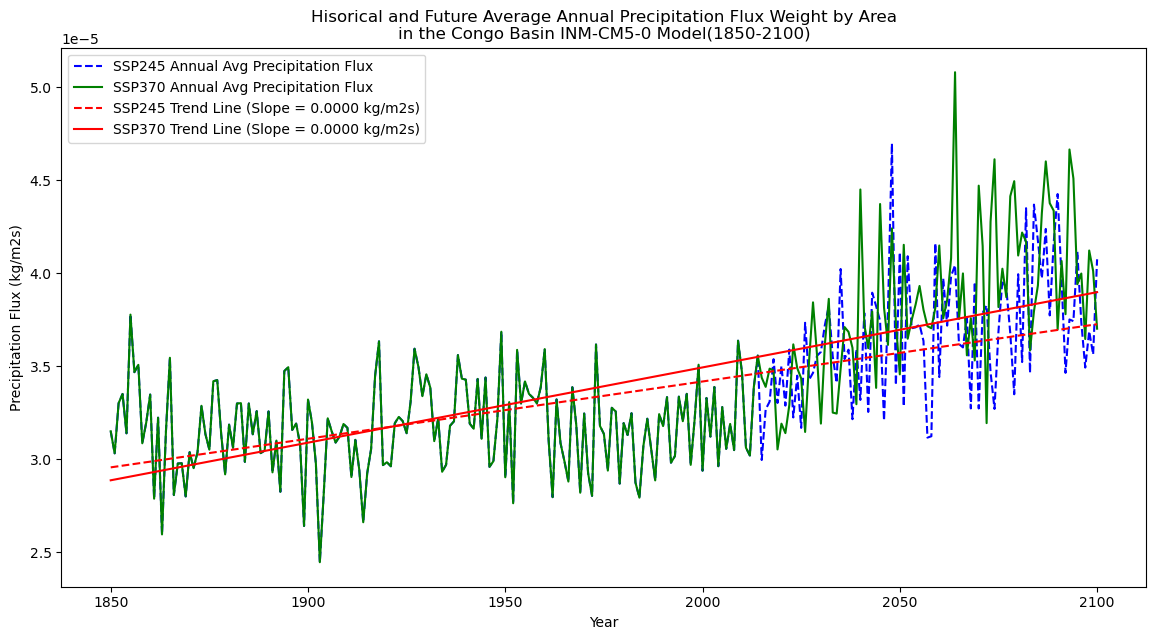

In [ ]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_inm_245.year, annual_mean_inm_245, label= 'SSP245 Annual Avg Precipitation Flux', color='blue', linestyle='--')
ax.plot(annual_mean_inm_370.year, annual_mean_inm_370, label= 'SSP370 Annual Avg Precipitation Flux', color='green')
ax.plot(annual_mean_inm_245.year, trend_line_245(annual_mean_inm_245.year), color='red', linestyle='--', label=f'SSP245 Trend Line (Slope = {x_inm_245[0]:.4f} kg/m2s)')
ax.plot(annual_mean_inm_370.year, trend_line_370(annual_mean_inm_370.year), color='red', label=f'SSP370 Trend Line (Slope = {x_inm_370[0]:.4f} kg/m2s)')

ax.set_title('Hisorical and Future Average Annual Precipitation Flux Weight by Area\nin the Congo Basin INM-CM5-0 Model (1850-2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()

### Plotting for GFDL model

In [ ]:
# Subsetting for gfdl model

# Select tas variable, store as xarray DataArray
pr_gfdl_370 = gfdl_370['pr']

# Weight our gfdl precipitation data
pr_gfdl_370 = weights(pr_gfdl_370)

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_gfdl_370 = (pr_gfdl_370.lat >= lat_min) & (pr_gfdl_370.lat <= lat_max)
congo_lon_gfdl_370 = (pr_gfdl_370.lon >= lon_min) & (pr_gfdl_370.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_gfdl_370 = pr_gfdl_370.where(congo_lat_gfdl_370 & congo_lon_gfdl_370, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_gfdl_370 = pr_congo_gfdl_370.mean(dim=["lat", "lon"])

In [42]:
# Converts calendar to standard format to troublshoot slicing errors
pr_congo_gfdl_370 = pr_congo_gfdl_370.convert_calendar('standard', use_cftime=False)

# Select a time period of interest
pr_congo_gfdl_370 = pr_congo_gfdl_370.sel(time=slice('1850-01-01', '2015-12-31'))

# Calculate the annual mean precipitation
annual_mean_gfdl_370 = pr_congo_gfdl_370.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_gfdl_370 = np.polyfit(annual_mean_gfdl_370.year, annual_mean_gfdl_370, 1)

# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x_gfdl_370)  

### Model 2 Historical Plot

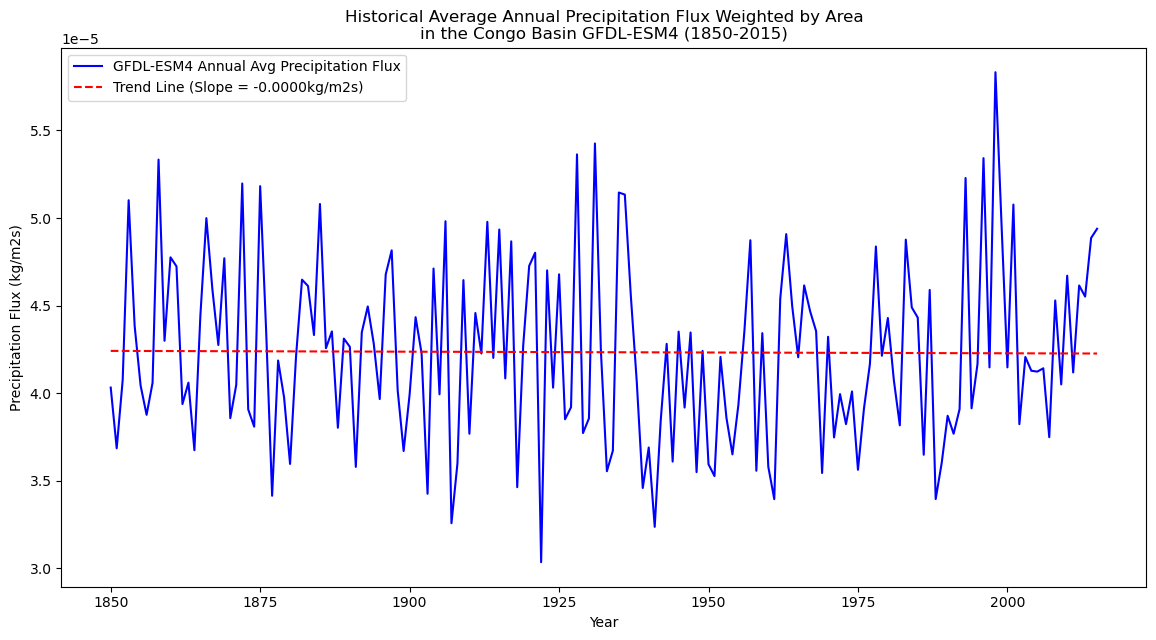

In [43]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_gfdl_370.year, annual_mean_gfdl_370, label= 'GFDL-ESM4 Annual Avg Precipitation Flux', color='blue')
ax.plot(annual_mean_gfdl_370.year, trend_line(annual_mean_gfdl_370.year), color='red', linestyle='--', label=f'Trend Line (Slope = {x_gfdl_370[0]:.4f}kg/m2s)')
ax.set_title('Historical Average Annual Precipitation Flux Weighted by Area\nin the Congo Basin GFDL-ESM4 (1850-2015)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()

Let's complete the above steps again for our GFDL ESM4 model for historical and future projections

In [44]:
# Select tas variable, store as xarray DataArray
pr_gfdl_245 = gfdl_245['pr']

# Weight our gfdl precipitation data
pr_gfdl_245 = weights(pr_gfdl_245)

# Subsetting for gfdl model
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
congo_lat_gfdl_245 = (pr_gfdl_245.lat >= lat_min) & (pr_gfdl_245.lat <= lat_max)
congo_lon_gfdl_245 = (pr_gfdl_245.lon >= lon_min) & (pr_gfdl_245.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_congo_gfdl_245 = pr_gfdl_245.where(congo_lat_gfdl_245 & congo_lon_gfdl_245, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_gfdl_245 = pr_congo_gfdl_245.mean(dim=["lat", "lon"])

In [ ]:
# Converts calendar to standard format to troublshoot slicing errors
pr_congo_gfdl_245 = pr_congo_gfdl_245.convert_calendar('standard', use_cftime=False)

# Select a time period of interest
pr_congo_gfdl_245 = pr_congo_gfdl_245.sel(time=slice('1850-01-01','2100-12-31'))

In [ ]:
# We also need to re-slice our 370 model to include the future projections...
# Find points where the mask value is True, drop all other points
pr_congo_gfdl_370 = pr_gfdl_370.where(congo_lat_gfdl_370 & congo_lon_gfdl_370, drop=True)

# Average over lat, lon dimensions to get a time series
pr_congo_gfdl_370 = pr_congo_gfdl_370.mean(dim=["lat", "lon"])

# Converts calendar to standard format to troublshoot slicing errors
pr_congo_gfdl_370 = pr_congo_gfdl_370.convert_calendar('standard', use_cftime=False)

# Re slice
pr_congo_gfdl_370 = pr_congo_gfdl_370.sel(time=slice('1850-01-01', '2100-12-31'))

In [47]:
# Calculate the annual mean precipitation for 245
annual_mean_gfdl_245 = pr_congo_gfdl_245.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_gfdl_245 = np.polyfit(annual_mean_gfdl_245.year, annual_mean_gfdl_245, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_245 = np.poly1d(x_gfdl_245)  

In [48]:
# Re-calculate the annual mean precipitation for 370
annual_mean_gfdl_370 = pr_congo_gfdl_370.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
x_gfdl_370 = np.polyfit(annual_mean_gfdl_370.year, annual_mean_gfdl_370, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_370 = np.poly1d(x_gfdl_370)  

### Model 2 Historical and Future Projections Plot

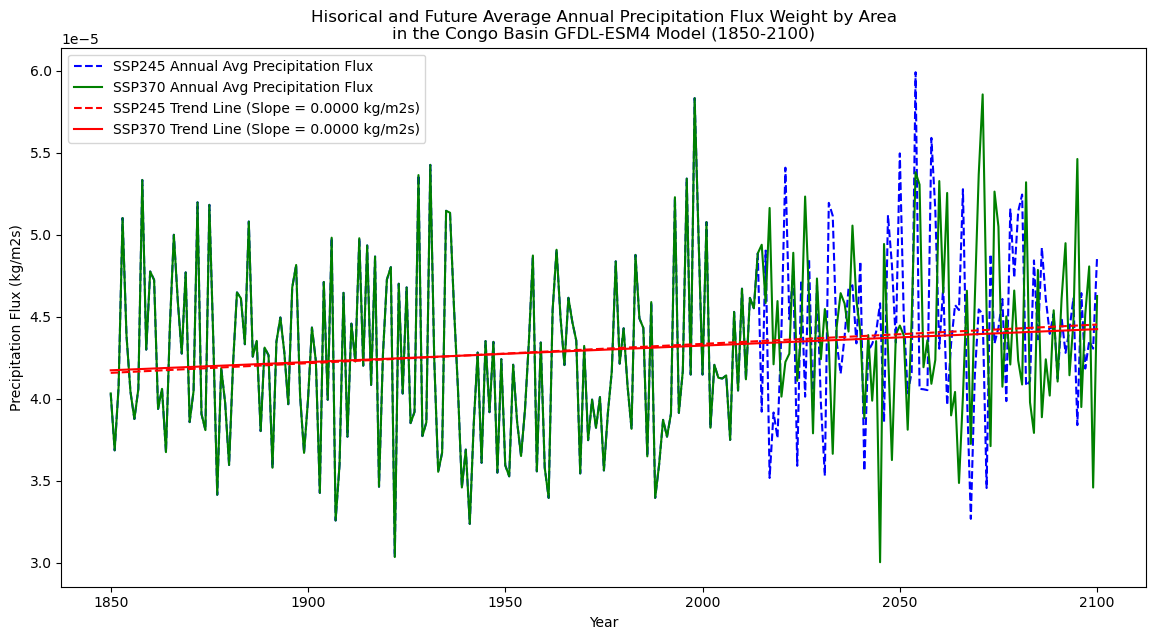

In [49]:
# Plot our annual data and the trend line
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(annual_mean_gfdl_245.year, annual_mean_gfdl_245, label= 'SSP245 Annual Avg Precipitation Flux', color='blue', linestyle='--')
ax.plot(annual_mean_gfdl_370.year, annual_mean_gfdl_370, label= 'SSP370 Annual Avg Precipitation Flux', color='green')
ax.plot(annual_mean_gfdl_245.year, trend_line_245(annual_mean_gfdl_245.year), color='red', linestyle='--', label=f'SSP245 Trend Line (Slope = {x_gfdl_245[0]:.4f} kg/m2s)')
ax.plot(annual_mean_gfdl_370.year, trend_line_370(annual_mean_gfdl_370.year), color='red', label=f'SSP370 Trend Line (Slope = {x_gfdl_370[0]:.4f} kg/m2s)')

ax.set_title('Hisorical and Future Average Annual Precipitation Flux Weight by Area\nin the Congo Basin GFDL-ESM4 Model (1850-2100)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation Flux (kg/m2s)')
ax.legend()
plt.show()